# Installs

In [ ]:
!pip install GDCM
!pip install pylibjpeg
!pip install pylibjpeg-libjpeg
!pip install dicomsdl

# Imports

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#import dicomsdl # reading dicom images
import pydicom
import cv2 # image algebra 
import PIL # pillow image formats
import matplotlib.pyplot as plt # EDA
import seaborn # make charts pretty
import os # OS Paths
from statsmodels.stats.outliers_influence import variance_inflation_factor
import gc
from tqdm.notebook import tqdm
import time

# Parallel processing library imports
from joblib import Parallel, delayed

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

tqdm.pandas()

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras as keras
tqdm.pandas()
from sklearn.model_selection import train_test_split
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from statistics import mean
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from imblearn.under_sampling import NearMiss
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
pd.options.display.max_rows = 999

In [101]:
scan = pydicom.dcmread('/kaggle/input/rsna-breast-cancer-detection/test_images/10008/1591370361.dcm')

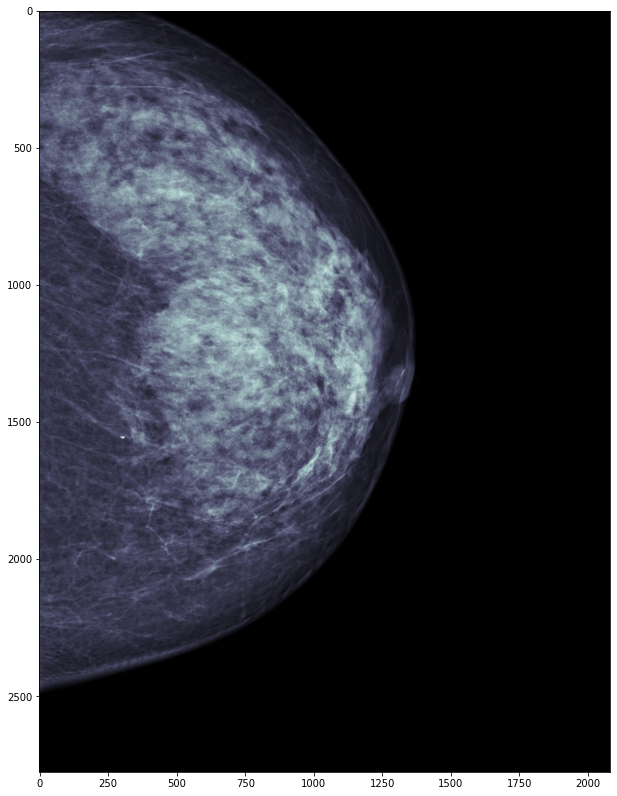

In [103]:
img = scan.pixel_array
fig = plt.figure(figsize=(20, 14))
plt.imshow(img,cmap='bone')

In [104]:
def clahe(img,clip):
    #contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=clip)
    cl = clahe.apply(np.array(img))
    return cl

In [110]:
img.shape

(2776, 2082)

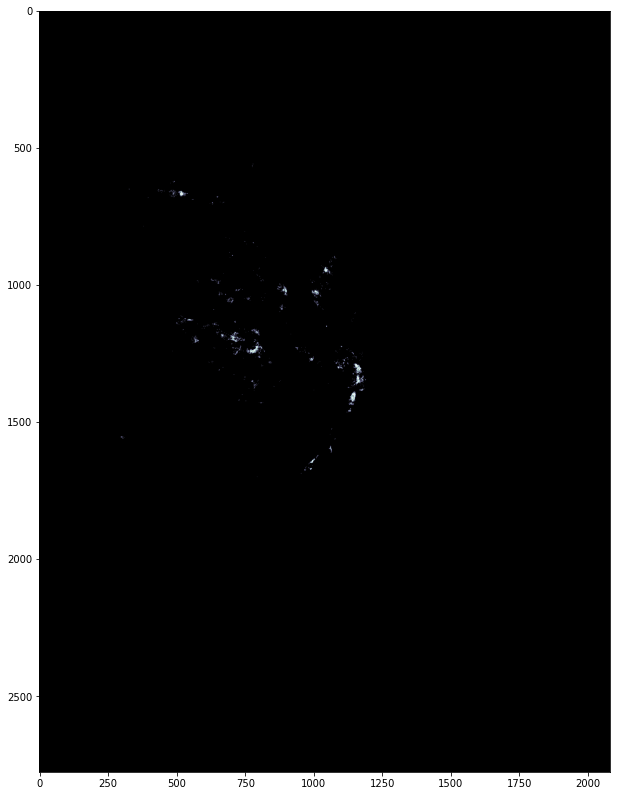

In [105]:
img = window(img)
fig = plt.figure(figsize=(20, 14))
plt.imshow(img, cmap = 'bone')

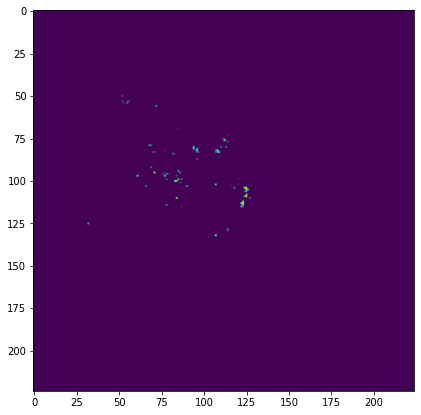

In [115]:
fig = plt.figure(figsize=(10, 7))
plt.imshow(cv2.resize(img,(224,224)))

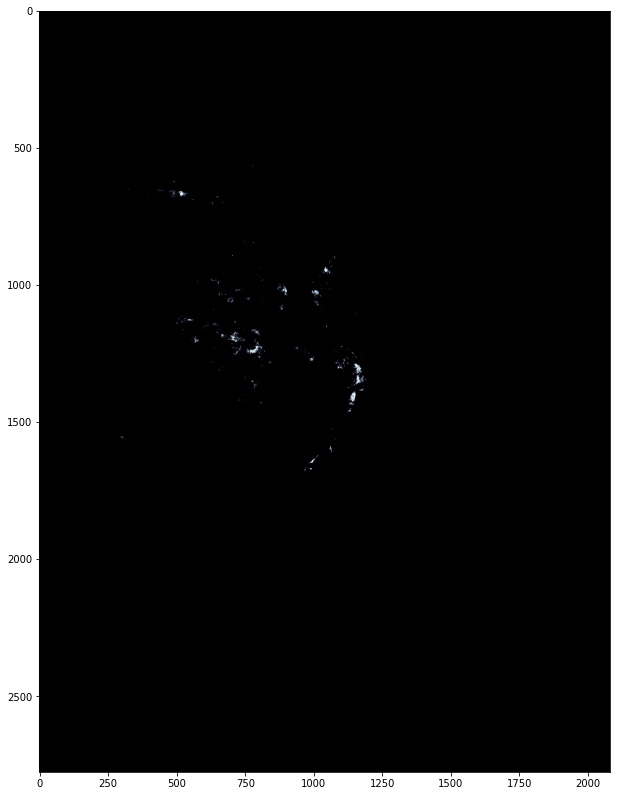

In [106]:
img = img/img.max()
img = img*255
img = img.astype(np.uint8)
img = clahe(img,1)
fig = plt.figure(figsize=(20, 14))
plt.imshow(img,cmap = 'bone')

In [57]:
img[2500:3000,2500:3000].max()

255

# Read Image Files, Preprocess, and Save as PNG


In [ ]:
class MammographyPreprocessor():
    
    # Constructor
    def __init__(self, paths: list, save_dir: str, size: tuple=None):
        self.size = size
        # implement the paths of the original RSNA dataset (V2)
        self.paths = paths
        self.save_dir = save_dir

    # Apply the preprocessing methods on one image
    def preprocess_single_image(self, path: str):
        scan = dicomsdl.open(path)
        img = scan.pixelData()
        img = self._fix_photometric_interpretation(img, scan)
        img = self._windowing(img, scan)
        img = self._normalize_to_255(img)
        img = self._flip_breast_side(img, scan)
        img = self._crop(img)
        img = self._resize(img)
        self._save_image(img, path)
        return img
    
    # Preprocess all the images from the paths
    def preprocess_all(self, n_jobs: int=4):
        clock = time.time()
        Parallel(n_jobs=n_jobs) \
        (delayed(self.preprocess_single_image) \
        (path) for path in tqdm(self.paths, total=len(self.paths)))
        print("Parallel preprocessing done!")
        print("Time =", np.around(time.time() - clock, 3), 'sec')
    
    # Adjust the contrast of an image
    def _windowing(self, img, scan):
        function = scan.VOILUTFunction
        if type(scan.WindowWidth) == list:
            center = scan.WindowCenter[0]
            width = scan.WindowWidth[0]
        else:
            center = scan.WindowCenter
            width = scan.WindowWidth
        y_range = 2**scan.BitsStored - 1
        if function == 'SIGMOID':
            img = y_range / (1 + np.exp(-4 * (img - center) / width))
            print(center)
            print(width)
        else: # LINEAR
            below = img <= (center - width / 2)
            above = img > (center + width / 2)
            between = np.logical_and(~below, ~above)
            print(center)
            print(width)
            print(below)
            print(above)
            print(between)
            img[below] = 0
            img[above] = y_range
            img[between] = ((img[between] - center) / width + 0.5) * y_range
        return img
    
    # Interpret pixels in a consistant way
    def _fix_photometric_interpretation(self, img, scan):
        if scan.PhotometricInterpretation == 'MONOCHROME1':
            return img.max() - img
        elif scan.PhotometricInterpretation == 'MONOCHROME2':
            return img - img.min()
        else:
            raise ValueError("Invalid Photometric Interpretation: {}"
                               .format(scan.PhotometricInterpretation))
    
    # Cast into 8-bits for saving
    def _normalize_to_255(self, img):
        if img.max() != 0:
            img = img / img.max()
        img *= 255
        return img.astype(np.uint8)
    
    # Flip the breast horizontally on the chosen side 
    def _flip_breast_side(self, img, scan):
        img_breast_side = self._determine_breast_side(img)
        if img_breast_side == 'L':
            return img
        else:
            return np.fliplr(img)    
    
    # Determine the current breast side
    def _determine_breast_side(self, img):
        col_sums_split = np.array_split(np.sum(img, axis=0), 2)
        left_col_sum = np.sum(col_sums_split[0])
        right_col_sum = np.sum(col_sums_split[1])
        if left_col_sum > right_col_sum:
            return 'L'
        else:
            return 'R'
    
    # Crop the useless background of the image
    def _crop(self, img):
        bin_img = self._binarize(img, threshold=5)
        contour = self._extract_contour(bin_img)
        img = self._erase_background(img, contour)
        x1, x2 = np.min(contour[:, :, 0]), np.max(contour[:, :, 0])
        y1, y2 = np.min(contour[:, :, 1]), np.max(contour[:, :, 1])
        x1, x2 = int(0.99 * x1), int(1.01 * x2)
        y1, y2 = int(0.99 * y1), int(1.01 * y2)
        return img[y1:y2, x1:x2]
    
    # Binarize the image at the threshold
    def _binarize(self, img, threshold):
        return (img > threshold).astype(np.uint8)
    
    # Get contour points of the breast
    def _extract_contour(self, bin_img):
        contours, _ = cv2.findContours(
            bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        contour = max(contours, key=cv2.contourArea)
        return contour
    
    # Set to background pixels of the image to zero
    def _erase_background(self, img, contour):
        mask = np.zeros(img.shape, np.uint8)
        cv2.drawContours(mask, [contour], -1, 255, cv2.FILLED)
        output = cv2.bitwise_and(img, mask)
        return output
    
    # Resize the image to the preprocessor size
    def _resize(self, img):
        return cv2.resize(img, self.size)
    
    # Get the save path of a given dicom file
    def _get_save_path(self, path):
        patient = path.split('/')[-2]
        filename = path.split('/')[-1]
        filename = filename.replace('dcm', 'png')
        if self.save_dir:
            save_path = os.path.join(self.save_dir,filename)
        else:
            save_path = os.path.join(os.getcwd(), patient, filename)
        return save_path
    
    # Save the preprocessed image
    def _save_image(self, img, path):
        save_path = self._get_save_path(path)
        cv2.imwrite(save_path, img)

In [ ]:
train_metadata.loc[(train_metadata['biopsy']==1)&(train_metadata['invasive']==0),'cancer'].value_counts()

In [92]:
subset = train_metadata.loc[(train_metadata['cancer']==0)&(train_metadata['density']=='A'),:]
subset.head(20)

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
510,1,10526,657541655,L,CC,57.0,0,0,0,2.0,0,A,49,False
511,1,10526,880953279,L,MLO,57.0,0,0,0,2.0,0,A,49,False
512,1,10526,376934385,R,CC,57.0,0,0,0,2.0,0,A,49,False
513,1,10526,1505027709,R,MLO,57.0,0,0,0,2.0,0,A,49,False
514,1,10526,1782974695,R,CC,57.0,0,0,0,2.0,0,A,49,False
590,1,1061,607898581,L,CC,41.0,0,0,0,1.0,0,A,49,False
591,1,1061,644553356,L,CC,41.0,0,0,0,1.0,0,A,49,False
592,1,1061,1862204230,L,MLO,41.0,0,0,0,1.0,0,A,49,False
593,1,1061,2027765245,L,MLO,41.0,0,0,0,1.0,0,A,49,False
594,1,1061,266246169,R,CC,41.0,0,0,0,1.0,0,A,49,False


In [ ]:
train_metadata.loc[train_metadata['patient_id']==12305]

In [ ]:
10102, 12305

In [ ]:
mp = MammographyPreprocessor(paths = [], save_dir="" , size=None)

In [100]:
def window(img):
    center = 190
    width = 620
    #-120 to 500
    window = [center-(width/2),center+(width/2)]
    max_val = img.max()
    min_val = (img[img>0]).min()
    A = np.array([[min_val, 1], [max_val, 1]])
    b = np.array([window[0],window[1]])
    x = np.linalg.solve(A, b)
    img = img*x[0]+x[1]
    img[img < 370] = 0
    img[img > 430] = 0
    return img

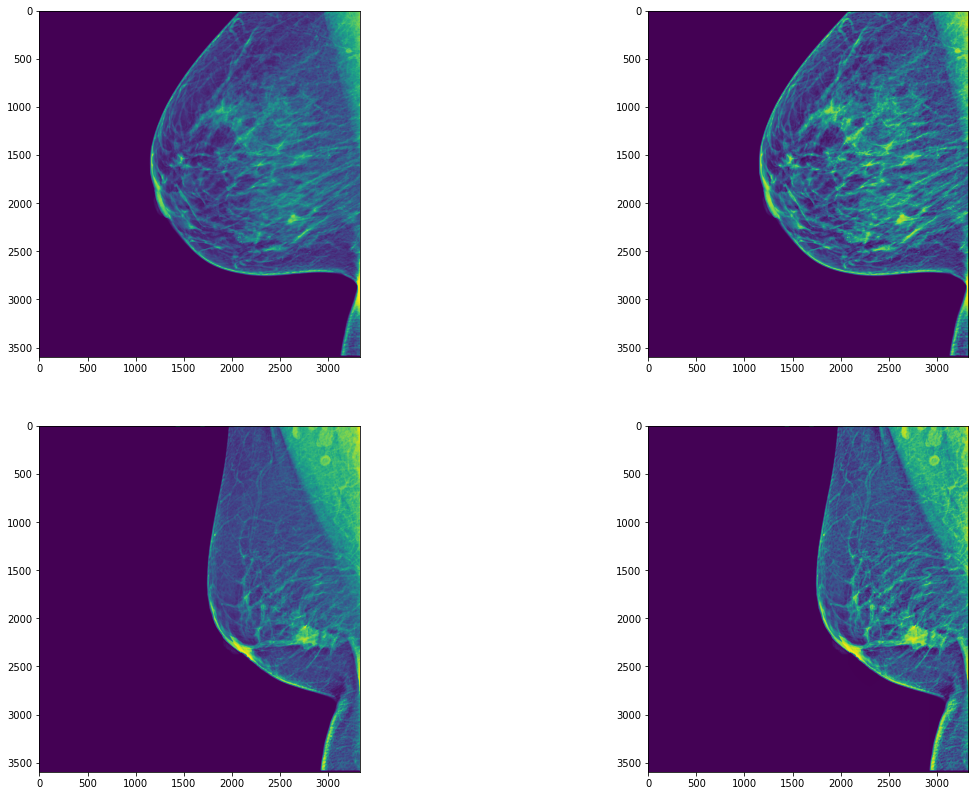

In [48]:
fig = plt.figure(figsize=(20, 14))
rows = 2
columns = 2
cmap = 'bone'
scan = pydicom.dcmread('/kaggle/input/rsna-breast-cancer-detection/train_images/64437/526841535.dcm')
img = scan.pixel_array
img = img[500:,:]
img = np.fliplr(img)
fig.add_subplot(rows, columns, 1)
plt.imshow(img)
img2 = img/img.max()
img2 = img2*255
img2 = img2.astype(np.uint8)
img2 = clahe(img2,1)
fig.add_subplot(rows, columns, 2)
plt.imshow(img2)

scan = pydicom.dcmread('/kaggle/input/rsna-breast-cancer-detection/train_images/22860/1938449367.dcm')
img3 = scan.pixel_array
img3 = img3[500:,:]
fig.add_subplot(rows, columns, 3)
plt.imshow(img3)
img4 = img3/img3.max()
img4 = img4*255
img4 = img4.astype(np.uint8)
img4 = clahe(img4,1)
fig.add_subplot(rows, columns, 4)
plt.imshow(img4)

In [49]:
img2[2000:2500,2500:3000].max()

242

In [ ]:
img2

In [ ]:
plt.imshow(img)

In [ ]:
def read_save_image(train_path,save_dir,size,n_jobs):
    paths = []
    folders = os.listdir(train_path)
    for folder in folders:
        files = os.listdir(os.path.join(train_path,folder))
        for file in files:
            path = os.path.join(train_path,folder,file)
            paths.append(path)
            
    mp = MammographyPreprocessor(paths,save_dir,size)
    mp.preprocess_all(n_jobs)

In [ ]:
train_path = '/kaggle/input/rsna-breast-cancer-detection/train_images/'
save_dir = '/kaggle/working/train/'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
n_jobs = 8
size = (1024,1024)
read_save_image(train_path, save_dir,size,n_jobs)

In [ ]:
test_path = "/kaggle/input/rsna-breast-cancer-detection/test_images/"
save_dir = '/kaggle/working/test/'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
n_jobs = 8
size = (1024,1024)
read_save_image(test_path, save_dir,size,n_jobs)

# Read Data files

In [58]:
train_metadata = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/train.csv")
train_metadata.head(5)

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [ ]:
test_metadata = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/test.csv")
test_metadata.head(5)

# Exploratory Data Analysis

**Data Imputation and Cleaning**

In [ ]:
train_metadata.columns

In [ ]:
for col in train_metadata.columns[3:]:
    print(col," : ",train_metadata[col].value_counts())
    print("\n")

In [ ]:
laterality_map = {"L":1,"R":0}
view_map = {'MLO':5,'CC':4,'AT':3,'LM':2,'ML':1,'LMO':0}
density_map = {'B':3,'C':2,'A':1,'D':0}
difficult_case_map = {False:1, True:0}

In [ ]:
train_metadata['laterality'] = train_metadata['laterality'].apply(lambda x: laterality_map[x] if x in laterality_map.keys() else x)
train_metadata['view'] = train_metadata['view'].apply(lambda x: view_map[x] if x in view_map.keys() else x)
train_metadata['density'] = train_metadata['density'].apply(lambda x: density_map[x] if x in density_map.keys() else x)
train_metadata['difficult_negative_case'] = train_metadata['difficult_negative_case'].apply(lambda x: difficult_case_map[x] if x in difficult_case_map.keys() else x)

In [ ]:
correlation = train_metadata[['laterality', 'view', 'age',
       'cancer', 'biopsy', 'invasive', 'implant','difficult_negative_case']].corr().round(2)
heatmap = seaborn.heatmap(correlation, annot = True)  
heatmap.set(xlabel = 'Metadata columns',ylabel = 'Metadata Columns', title = "Correlation matrix\n")  
plt.show()  

In [ ]:
for col in train_metadata.columns[3:]:
    print(col," : ",pd.isna(train_metadata[col]).value_counts()/len(train_metadata))
    print("\n")

Columns with over 40% data missing cannot be taken in for analysis and hence will be dropped. For other columns, since the empty values are fairly low in percentage points, the cases with empty values will be dropped.

In [ ]:
missingdata_ids = train_metadata.loc[pd.isna(train_metadata['age']),'patient_id'].to_list()
for id in missingdata_ids:
    train_metadata.drop(train_metadata.loc[train_metadata['patient_id']==id,:].index,inplace = True,axis = 0)
    
train_metadata.drop(['BIRADS','density'],inplace = True,axis = 1)

In [ ]:
for col in train_metadata.columns[3:]:
    print(col," : ",pd.isna(train_metadata[col]).value_counts()/len(train_metadata))
    print("\n")

In [ ]:
# the independent variables set
X = train_metadata[['laterality', 'view', 'age',
       'cancer', 'biopsy', 'invasive', 'implant','difficult_negative_case']]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

Seems like view, age and difficult case are very highly correlated

In [ ]:
train_metadata[['age','cancer']].value_counts()/len(train_metadata)

Seems like views 4 and 5 contain the majority of the data. For view 4, 5 and others there will be parallel encoder decoder modules, gated with a condition. Since the output has to predict on all images in the test dataset, it will have to pass all rows as separate items. Hence, when one row is inserted in the model it will trigger the respective encoder decoder based on the view type.

In [ ]:
'''
train_metadata['age_bins'] = pd.qcut(train_metadata['age'], q=10)
age_bins = pd.qcut(train_metadata['age'], q=10).unique().categories
age_bin_map = {}
for index in tqdm(range(len(age_bins))):
    bucket = age_bins[index]
    age_bin_map[bucket] = index
train_metadata['age_bins'] = train_metadata['age_bins'].progress_apply(lambda x: age_bin_map[x])
'''

In [ ]:
age_bins = {1:[26,28,29,30,31,32,33,34,35,36,37,85,87],
            2:[42,44,49,47,43,40,41,57,51,46,78,54,59,48,52],
            3:[50,66,45,62,58,38,53,69,55,56,60,64,63,84,61,65,67],
            4:[77,68,71,86,70,39,73,83,81,89,76,72,79,75,80,82,74,88]}

In [ ]:
def age_bin_apply(x):
    a_bin = 1
    for key in age_bins.keys():
        if x in age_bins[key]:
            a_bin = key
    return a_bin

In [ ]:
train_metadata['age_bins'] = train_metadata['age'].progress_apply(lambda x: age_bin_apply(x))

In [ ]:
train_metadata[['age_bins','cancer']].value_counts()

# Fixing Test Data

In [ ]:
test_metadata['laterality'] = test_metadata['laterality'].apply(lambda x: laterality_map[x] if x in laterality_map.keys() else x)
test_metadata['view'] = test_metadata['view'].apply(lambda x: view_map[x] if x in view_map.keys() else x)

In [ ]:
def apply_age_bins(x):
    for age_bin in age_bins:
        if x['age'] in age_bin:
            return age_bin_map[age_bin]

In [ ]:
test_metadata['age_bins'] = test_metadata.apply(lambda x: apply_age_bins(x),axis =1)

In [ ]:
test_metadata.head()

# Read Corresponding Images Data

**Reading only difficult images and cancer images to classify**

In [ ]:
train_set1 = train_metadata.loc[train_metadata['cancer']==1]
train_set2 = train_metadata.loc[train_metadata['difficult_negative_case']==0]
train_set = pd.concat([train_set1,train_set2],axis = 0)
train_set.drop_duplicates(inplace=True)
train_set.head()

In [ ]:
train_images_path = "/kaggle/input/bcdtrain/train_2/"
train_images = {}
for index in tqdm(train_set.index):
    row = train_set.loc[index,:]
    folder = str(int(row['patient_id']))
    file = str(int(row['image_id']))
    if not folder in train_images.keys():
        train_images[folder] = {}
    train_images[folder][file] = "/kaggle/input/bcdtrain/train_2/"+folder+'/'+file+'.png'

In [ ]:
test_images_path = "/kaggle/working/test/"
test_images = {}
for index in tqdm(test_metadata.index):
    row = test_metadata.loc[index,:]
    folder = str(int(row['patient_id']))
    file = str(int(row['image_id']))
    if not folder in test_images.keys():
        test_images[folder] = {}
    test_images[folder][file] = test_images_path+file+".png"

# Creating iteratable dataset

In [ ]:
'''
train_set['image'] = train_set.progress_apply(lambda x: train_images[str(int(x['patient_id']))][str(int(x['image_id']))],axis = 1)
del(train_images)
gc.collect()
'''

In [ ]:
test_metadata['image'] = test_metadata.progress_apply(lambda x: test_images[str(int(x['patient_id']))][str(int(x['image_id']))],axis = 1)
del(test_images)
gc.collect()

In [ ]:
undersample = NearMiss(version=1, n_neighbors=3)
X, y = undersample.fit_resample(train_set.drop(['site_id'],axis = 1),train_set['cancer'])

In [ ]:
X['image'] = X.progress_apply(lambda x: train_images[str(int(x['patient_id']))][str(int(x['image_id']))],axis = 1)
del train_images
gc.collect()

In [ ]:
#X_train, X_valid, Y_train, Y_valid = train_test_split(train_set[['view','age_bins','implant','image']],train_set['cancer'],test_size = 0.1,random_state=42)
X_train, X_valid, Y_train, Y_valid = train_test_split(X[['view','age_bins','implant','image']],y,test_size = 0.1,random_state=42)

In [ ]:
class dataset:
    def __init__(self,data,target = None, dataset_type = 'train'):
        self.dataset_type = dataset_type
        self.images = data['image'].to_list()
        self.views = data['view'].to_list()
        self.age_bins = data['age_bins'].to_list()
        self.implants = data['implant'].to_list()
        if self.dataset_type == 'train':
            self.target = target.tolist()
            
    
    def randomize(self):
        p = np.random.permutation(len(self.images)).tolist()
        self.images = [self.images[i] for i in p]
        self.views = [self.views[i] for i in p]
        self.age_bins = [self.age_bins[i] for i in p]
        self.implants = [self.implants[i] for i in p]
        if self.dataset_type == 'train':
            self.target = [self.target[i] for i in p]
            
    def generate_batches(self, batch_size):
        #num_batches = len(self.images) // batch_size 
        for i in range(0,len(self.images),batch_size):
            if i < len(self.images) - 1:
                if i + batch_size < len(self.views) - 1:
                    views_batch = np.array(self.views[i:i+batch_size])
                    age_batch = np.array(self.age_bins[i:i+batch_size]).astype(float)
                    implants_batch = np.array(self.implants[i:i+batch_size]).astype(float)
                    if self.dataset_type == 'train':
                        target_batch = np.vstack([np.array(target) for target in self.target[i:i+batch_size]]).astype(float)
                    images_batch = []
                    for path in self.images[i:i+batch_size]:
                        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
                        img = img.reshape(img.shape[0],img.shape[1],1)
                        images_batch.append(img)
                    images_batch = np.array(images_batch)
                else:
                    views_batch = np.array(self.views[i:])
                    age_batch = np.array(self.age_bins[i:]).astype(float)
                    implants_batch = np.array(self.implants[i:]).astype(float)
                    if self.dataset_type == 'train':
                        target_batch = np.vstack([np.array(target) for target in self.target[i:]]).astype(float)
                    images_batch = []
                    for path in self.images[i:]:
                        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
                        img = img.reshape(img.shape[0],img.shape[1],1)
                        images_batch.append(img)
                    images_batch = np.array(images_batch)
                cat_batch = np.vstack([implants_batch,age_batch])
                cat_batch = cat_batch.transpose()
            if self.dataset_type == 'train':
                yield cat_batch, views_batch, images_batch, target_batch
            else:
                yield cat_batch, views_batch, images_batch, 0
    
    def size(self):
        return len(self.images)
    
    def num_batches(self,batch_size):
        if len(self.images) % batch_size == 0:
            num_batches = len(self.images) // batch_size
        else:
            num_batches = len(self.images) // batch_size
            num_batches += 1
        return num_batches

In [ ]:
train_dataset = dataset(X_train,Y_train)

In [ ]:
for cat_batch, views_batch, images_batch, target_batch in train_dataset.generate_batches(200):
    print(cat_batch.shape)
    break

In [ ]:
img = images_batch[50]

# Display what has been loaded
plt.imshow(img, cmap='jet')
plt.colorbar()
plt.show()

In [ ]:
test_dataset = dataset(test_metadata,dataset_type = 'test')

In [ ]:
for cat_batch, views_batch, images_batch, target_batch in test_dataset.generate_batches(100):
    print(cat_batch.shape)
    break

In [ ]:
img = images_batch[2]
print(img.shape)
# Display what has been loaded
plt.imshow(img, cmap='jet')
plt.colorbar()
plt.show()

# VGG16 inspired encoder model

In [ ]:
'''
class encoder(tf.keras.Model):
    def __init__(self,size:tuple):
        super(encoder, self).__init__()
        #encoder Module
        self.input_cnn = keras.layers.InputLayer(input_shape = (size[0],size[1],size[2]))
        # 3x3 Filter first application
        self.conv_1 = keras.layers.Conv2D(input_shape = (size[0],size[1],size[2]),filters = 64, kernel_size=(3,3),padding='same',activation='relu')
        self.conv_2 = keras.layers.Conv2D(filters = 64,kernel_size=(3,3),padding='same',activation='relu')
        # 1/2 size reduction
        self.conv_3 = keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2))
        # 3x3 Filter second application
        self.conv_4 = keras.layers.Conv2D(filters = 128,kernel_size=(3,3),padding='same',activation='relu')
        self.conv_5 = keras.layers.Conv2D(filters = 128,kernel_size=(3,3),padding='same',activation='relu')
        # 1/2 size reduction
        self.conv_6 = keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2))
        # 3x3 Filter third application
        self.conv_7 = keras.layers.Conv2D(filters = 256,kernel_size=(3,3),padding='same',activation='relu')
        self.conv_8 = keras.layers.Conv2D(filters = 256,kernel_size=(3,3),padding='same',activation='relu')
        # 1/2 size reduction
        self.conv_9 = keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2))
        # 3x3 Filter fourth application
        self.conv_10 = keras.layers.Conv2D(filters = 512,kernel_size=(3,3),padding='same',activation='relu')
        self.conv_11 = keras.layers.Conv2D(filters = 512,kernel_size=(3,3),padding='same',activation='relu')
        # 1/2 size reduction
        self.conv_12 = keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2))
        # 3x3 feature reduction
        self.conv_13 = keras.layers.Conv2D(filters = 128 ,kernel_size=(3,3),padding='same',activation='relu')
        # 1/2 size reduction
        self.conv_14 = keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2))
    
    def call(self,inputs):
        x = self.input_cnn(inputs)
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = self.conv_4(x)
        x = self.conv_5(x)
        x = self.conv_6(x)
        x = self.conv_7(x)
        x = self.conv_8(x)
        x = self.conv_9(x)
        x = self.conv_10(x)
        x = self.conv_11(x)
        x = self.conv_12(x)
        x = self.conv_13(x)
        x = self.conv_14(x)
        return x

    
class classifier(tf.keras.Model):
    def __init__(self,units):
        super(classifier, self).__init__()
        # Feature Reduction layer 1
        self.dense1 = keras.layers.Dense(units,activation = 'relu')
        
        # Feature Reduction Layer 2
        self.dense2 = keras.layers.Dense(int(units/2),activation = 'relu')
        
        # Feature Reduction Layer 3
        self.dense3 = keras.layers.Dense(int(units/4),activation = 'relu')
        
        # Dropout Layer
        self.dropout = keras.layers.Dropout(0.1)
        
        # Feature Reduction Layer 4
        self.dense4 = keras.layers.Dense(int(units/8),activation = 'relu')
        
        # Feature Reduction Layer 5
        self.dense5 = keras.layers.Dense(int(units/16),activation = 'relu')
        
        # Feature Reduction Layer 6
        self.dense6 = keras.layers.Dense(int(units/32),activation = 'relu')
        
        
        
        # Feature Reduction Layer 7
        self.dense7 = keras.layers.Dense(1,activation = 'sigmoid')
    
    def call(self,inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dropout(x)        
        x = self.dense4(x)
        x = self.dense5(x)
        x = self.dense6(x)
        x = self.dense7(x)
        return x


class BCDClassifier(tf.keras.Model):
    def __init__(self, optimizer = keras.optimizers.Adam(learning_rate=1e-3),loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)):
        super(BCDClassifier, self).__init__()
       
        #Input for catagorical data
        self.input_cat = keras.layers.InputLayer(input_shape = 2,name = "DNN Input: Categorical Features")
        
        #Encoder Layer for each view
        self.encode_5 = encoder((1024,1024,3))
        self.encode_4 = encoder((1024,1024,3))
        self.encode_o = encoder((1024,1024,3))
        
        #Flatten layer to flatten outputs
        self.flatten = keras.layers.Flatten()
        
        #Concatenate Layer
        self.concat = keras.layers.Concatenate(axis = 1)
        
        #Classifier layer
        self.classify = classifier(512)
        
        #final concat
        self.concat2 = keras.layers.Concatenate(axis = 0)
    
    # Forward pass of model - order does matter.
    def call(self, cat_batch, view_batch, images_batch):
        z = tf.reshape(tf.convert_to_tensor(()), (0, 1))
        for index in range(0,len(cat_batch)):
            x1 = tf.cond(view_batch[index] == 5, lambda: self.encode_5(images_batch[index].reshape(1,1024,1024,3)), \
                         lambda: tf.cond(view_batch[index] == 4, lambda: self.encode_4(images_batch[index].reshape(1,1024,1024,3)),\
                                        lambda: self.encode_o(images_batch[index].reshape(1,1024,1024,3))))
                
            #calling Categorical processor
            x2 = self.input_cat(cat_batch[index])
            
            #calling 
            x1 = self.flatten(x1)
            x2 = tf.reshape(x2,(1,x2.shape[0]))
            x12 = self.concat([x1,x2])
            x12 = self.classify(x12)
            
            #concat to one output
            z = self.concat2([z,x12])
            
        return z 

    def fit(self, epochs, dataset, batch_size,log_after_steps = 200 ,verbose = 1):
        if verbose == 1:
            pb1 = tqdm(total= epochs)
            pb2 = tqdm(total= dataset.size())
        for epoch in range(epochs):
            print("\nStart of epoch %d" % (epoch,))
            step = 0
            for cat_batch, views_batch, images_batch, target_batch in dataset.generate_batches(batch_size):

                # Open a GradientTape to record the operations run
                # during the forward pass, which enables auto-differentiation.
                with tf.GradientTape() as tape:

                    # Run the forward pass of the layer.
                    # The operations that the layer applies
                    # to its inputs are going to be recorded
                    # on the GradientTape.
                    logits = model(cat_batch, views_batch, images_batch)  # Logits for this minibatch
                    print(target_batch.shape)
                    print(logits.shape)
                    # Compute the loss value for this minibatch.
                    loss_value = loss_fn(target_batch, logits)

                # Use the gradient tape to automatically retrieve
                # the gradients of the trainable variables with respect to the loss.
                grads = tape.gradient(loss_value, model.trainable_weights)

                # Run one step of gradient descent by updating
                # the value of the variables to minimize the loss.
                optimizer.apply_gradients(zip(grads, model.trainable_weights))
                
                step += 1

                # Log every 200 steps.
                if step % log_after_steps == 0:
                    print(
                        "Training loss (for one batch) at step %d: %.4f"
                        % (step, float(loss_value))
                    )
                    print("Seen so far: %s samples" % ((step + 1) * batch_size))
                if verbose == 1:
                    pb2.update(len(cat_batch))
            if verbose == 1:
                pb1.update()
            
    def prep_for_build(self):
        #Build for all Views
        cat_batch = []
        view_batch = []
        images_batch = []
        cat_batch.append(np.zeros(2))
        view_batch.append(np.array(1))
        images_batch.append(np.zeros((1024,1024,3)))
        cat_batch.append(np.zeros(2))
        view_batch.append(np.array(4))
        images_batch.append(np.zeros((1024,1024,3)))
        cat_batch.append(np.zeros(2))
        view_batch.append(np.array(5))
        images_batch.append(np.zeros((1024,1024,3)))  
        cat_batch = np.asarray(cat_batch)
        view_batch = np.asarray(view_batch)
        images_batch = np.asarray(images_batch)
        output = model(cat_batch, view_batch, images_batch)        
        return output
'''

# Custom CNN Model

In [ ]:
class encoder(tf.keras.layers.Layer):
    def __init__(self,size:tuple):
        super(encoder, self).__init__()
        #encoder Module
        self.input_cnn = keras.layers.InputLayer(input_shape=(size[0],size[1],size[2]))
        # Ex0panding features for computation
        self.conv_1 = keras.layers.Conv2D(input_shape=(size[0],size[1],size[2]),filters=8,kernel_size=(3,3),padding='same',activation='relu')
        # 1/4 size reduction
        self.conv_2 = keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2))
        self.conv_3 = keras.layers.Conv2D(filters = 16,kernel_size=(4,4),strides=(2,2),padding='same',activation='relu')
        self.conv_4 = keras.layers.Conv2D(filters = 32,kernel_size=(4,4),strides=(4,4),padding='same',activation='relu')
        self.conv_5 = keras.layers.BatchNormalization()
        # 1/2 size reduction
        self.conv_6 = keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2))
        # 3x3 Filter third application
        self.conv_7 = keras.layers.Conv2D(filters = 64,kernel_size=(8,8),strides=(8,8),padding='same',activation='relu')
        # 1/4 size reduction
        self.conv_8 = keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2))
        # 3x3 Filter third application
        self.conv_9 = keras.layers.BatchNormalization()
        self.conv_10 = keras.layers.Conv2D(filters = 1 ,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')
        #Flatten output
        self.flatten = keras.layers.Flatten()
        
    
    def call(self,inputs,training = True):
        x = self.input_cnn(inputs)
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = self.conv_4(x)
        if training == True:
            x = self.conv_5(x,training = True)
        else:
            x = self.conv_5(x,training = False)
        x = self.conv_6(x)
        x = self.conv_7(x)
        x = self.conv_8(x)
        if training == True:
            x = self.conv_9(x,training = True)
        else:
            x = self.conv_9(x,training = False)
        x = self.conv_10(x)
        x = self.flatten(x)
        return x

In [ ]:
en = encoder((1024,1024,1))
y = en(images_batch)

print("Weights: ", len(en.trainable_weights))

In [ ]:
class classifier(tf.keras.layers.Layer):
    def __init__(self,units):
        super(classifier, self).__init__()
        
        # Feature Reduction layer 1
        self.dense1 = keras.layers.Dense(units,activation = 'relu')
        
        # Dropout Layer
        #self.dropout = keras.layers.Dropout(0.1)
        
        # Feature Reduction Layer 2
        self.dense2 = keras.layers.Dense(int(units/8),activation = 'relu')
        
        # Classification Layer
        self.dense3 = keras.layers.Dense(1,activation = 'sigmoid')
    
    def call(self,inputs): 
        x = self.dense1(inputs)
        x = self.dense2(x)
        #x = self.dropout(x)
        x = self.dense3(x)
        return x

In [ ]:
inputs = np.zeros((1049385,1))
cl = classifier(32)
y = cl(inputs)

print("Weights :", len(cl.trainable_weights))

In [ ]:
class BCDClassifier(tf.keras.Model):
    def __init__(self, size: tuple, optimizer = keras.optimizers.Adam(learning_rate=1e-3),loss_fn = keras.losses.BinaryCrossentropy(from_logits=False),metric = tf.keras.metrics.Accuracy()):
        super(BCDClassifier, self).__init__()
       
        #Input for catagorical data
        self.input_cat = keras.layers.InputLayer(input_shape = 2)
        
        #Encoder Layer for each view
        self.encode = encoder(size)
        
        #Concatenate Layer
        self.concat = keras.layers.Concatenate(axis = 1)
        
        #Classifier layer
        self.classify = classifier(32)
        
        #deffine model parameters
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = metric
        self.f1_tracker = tfa.metrics.F1Score(num_classes=2, threshold=0.5, average = 'micro')
        self.sk_metric_acc = accuracy_score
        self.sk_metric_f1 = f1_score
        self.acc_history = []
        self.loss_history = []
        self.f1_history = []

        
    # Forward pass of model - order does matter.
    def call(self, cat_batch, view_batch, images_batch, training = True):
        x1 = self.encode(images_batch,training)
                
        #calling Categorical processor
        x2 = self.input_cat(cat_batch)
            
        #calling 
        x12 = self.concat([x1,x2])
        x12 = self.classify(x12)          
        return x12
    
    def train_step(self,cat_batch, views_batch, images_batch, target_batch, training = True):
        
        with tf.GradientTape() as tape:
            logits = self(cat_batch, views_batch, images_batch,training)
            loss_value = self.loss_fn(target_batch, logits)

        grads = tape.gradient(loss_value, self.trainable_weights)

        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.loss_tracker.update_state(loss_value)
        
        pred = []
        target = []
        for val in logits.numpy():
            for v_1 in val:
                if isinstance(v_1,np.ndarray):
                    if v_1[0] > 0.5:
                        pred.append(1.0)
                    else:
                        pred.append(0.0)
                else:
                    if v_1 > 0.5:
                        pred.append(1.0)
                    else:
                        pred.append(0.0)
        for val in target_batch:
            if isinstance(val,np.ndarray):
                for v_1 in val:
                    target.append(v_1)
            else:
                target.append(val)
        
        acc = self.sk_metric_acc(target,pred)
        f1 = self.sk_metric_f1(target,pred)
        self.f1_tracker.update_state(target_batch,logits)
        return {"Loss": self.loss_tracker.result(), "Accuracy": acc, 'F1-score':f1}
    
    def fit(self, train_dataset, test_dataset, epochs = 10, batch_size = 10, log_after_steps = 1000, verbose = 1):
        if verbose == 1:
            train_dataset.randomize()
            for epoch in tqdm(range(1,epochs+1), total = epochs, desc = "Epochs "):
                print("\nStart of epoch %d" % (epoch,))
                step = 0
                self.counter = 0
                for cat_batch, views_batch, images_batch, target_batch in tqdm(train_dataset.generate_batches(batch_size),total=train_dataset.num_batches(batch_size),desc = "Trained on batches"):
                    train_out = self.train_step(cat_batch, views_batch, images_batch, target_batch, training = True)
                    step += batch_size

                    # Log every 200 steps.
                    if step % log_after_steps == 0:
                        print("Training loss at step %d: %.4f"  % (step, train_out['Loss'].numpy()))
                        print("Training Accuracy at step %d: %.4f"  % (step, train_out['Accuracy']))
                        print("Training F1 at step %d: %.4f"  % (step, train_out['F1-score']),'\n')

                loss, acc, f1 = self.eval(test_dataset, batch_size)
                print("Eval Loss for epoch: ",loss.numpy())
                print("Eval Accuracy for epoch: ",acc)
                print("Eval F1 for epoch: ",f1)
                self.acc_history.append(acc)
                self.loss_history.append(loss.numpy())
                self.f1_history.append(f1)

        else:
            train_dataset.randomize()
            for epoch in range(1,epochs+1):
                print("\nStart of epoch %d" % (epoch,))
                step = 0
                self.counter = 0
                for cat_batch, views_batch, images_batch, target_batch in train_dataset.generate_batches(batch_size):
                    train_out = self.train_step(cat_batch, views_batch, images_batch, target_batch, training = True)
                    step += batch_size

                    # Log every 200 steps.
                    if step % log_after_steps == 0:
                        print("Training loss at step %d: %.4f"  % (step, train_out['Loss'].numpy()))
                        print("Training Accuracy at step %d: %.4f"  % (step, train_out['Accuracy']))
                        print("Training F1 at step %d: %.4f"  % (step, train_out['F1-score']),'\n')
                        
                loss, acc, f1 = self.eval(test_dataset, batch_size)
                print("Eval Loss for epoch: ",loss.numpy())
                print("Eval Accuracy for epoch: ",acc)
                print("Eval F1 for epoch: ",f1)
                self.acc_history.append(acc)
                self.loss_history.append(loss.numpy())
                self.f1_history.append(f1)
            
    def eval(self, dataset, batch_size, threshold = 0.5, verbose =1):
        step = 0
        if verbose == 1:
            out = []
            target = []
            final_out = []
            final_target = []
            for cat_batch, views_batch, images_batch, target_batch in tqdm(dataset.generate_batches(batch_size),total=dataset.num_batches(batch_size),desc = "Evaluated on batches"):
                logits = self(cat_batch, views_batch, images_batch,training=False)  
                # Compute the loss value for this minibatch.
                loss_value = self.loss_fn(target_batch, logits)
                self.loss_tracker.update_state(loss_value)
                self.acc_tracker.update_state(logits,target_batch)
                self.f1_tracker.update_state(target_batch,logits)
                out.append(logits.numpy())
                target.append(target_batch)
            for val in out:
                for v_1 in val:
                    if isinstance(v_1,np.ndarray):
                        if v_1[0] > threshold:
                            final_out.append(1.0)
                        else:
                            final_out.append(0.0)
                    else:
                        if v_1 > threshold:
                            final_out.append(1.0)
                        else:
                            final_out.append(0.0)
            for val in target:
                if isinstance(val,np.ndarray):
                    for v_1 in val:
                        final_target.append(v_1)
                else:
                    final_target.append(val)
        else:
            out = []
            target = []
            final_out = []
            final_target = []
            for cat_batch, views_batch, images_batch, target_batch in dataset.generate_batches(batch_size):
                logits = self(cat_batch, views_batch, images_batch, training=False)  
                # Compute the loss value for this minibatch.
                loss_value = self.loss_fn(target_batch, logits)
                self.loss_tracker.update_state(loss_value)
                self.acc_tracker.update_state(logits,target_batch)
                self.f1_tracker.update_state(target_batch,logits)
                out.append(logits.numpy())
                target.append(target_batch)
            for val in out:
                for v_1 in val:
                    if isinstance(v_1,np.ndarray):
                        if v_1[0] > threshold:
                            final_out.append(1.0)
                        else:
                            final_out.append(0.0)
                    else:
                        if v_1 > threshold:
                            final_out.append(1.0)
                        else:
                            final_out.append(0.0)
            for val in target:
                if isinstance(val,np.ndarray):
                    for v_1 in val:
                        final_target.append(v_1)
                else:
                    final_target.append(val)
        return self.loss_tracker.result(), self.sk_metric_acc(final_target,final_out), self.sk_metric_f1(final_target,final_out)
    
    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [self.loss_tracker, self.acc_tracker, self.f1_tracker]
         
    def build_graph(self):
        #Build for all Views
        cat_batch = []
        view_batch = []
        images_batch = []
        cat_batch.append(np.zeros(2))
        view_batch.append(np.array(1))
        images_batch.append(np.zeros((1024,1024,1))) 
        cat_batch = np.asarray(cat_batch)
        view_batch = np.asarray(view_batch)
        images_batch = np.asarray(images_batch)
        output = self(cat_batch, view_batch, images_batch, training = True)        
        return output
    
    def predict(self, dataset):
        out = []
        target = []
        final_out = []
        final_target = []
        for cat_batch, views_batch, images_batch, target_batch in tqdm(dataset.generate_batches(batch_size=10),total=dataset.num_batches(batch_size=10),desc = "Predicting Batches"):
            logits = model(cat_batch, views_batch, images_batch, training = False)
            out.append(logits.numpy())
            target.append(target_batch)
        for val in out:
            for v_1 in val:
                final_out.append(v_1[0])
        for val in target:
            if isinstance(val,np.ndarray):
                for v_1 in val:
                    final_target.append(v_1)
            else:
                final_target.append(val)
        return final_out, final_target

In [ ]:
model = BCDClassifier((images_batch.shape[1],images_batch.shape[2],images_batch.shape[3]))
model.build_graph()
model.summary()

In [ ]:
model.fit(train_dataset, test_dataset, epochs = 150, batch_size = 10, log_after_steps = 1000, verbose = 1)

In [ ]:
sub_dataset = dataset(test_metadata,dataset_type = 'test')

In [ ]:
y_pred_sub, y_true_sub = model.predict(sub_dataset)

In [ ]:
y_pred, y_true = model.predict(test_dataset)

In [ ]:
y_pred_2 = []
for item in y_pred:
    if item > 0.5:
        y_pred_2.append(1.0)
    else:
        y_pred_2.append(0.0)

In [ ]:
rep = classification_report(y_true,y_pred_2,output_dict=True)
df = pd.DataFrame(rep).transpose()

In [ ]:
df

In [ ]:
acc = accuracy_score(y_true,y_pred_2)

In [ ]:
acc

In [ ]:
y_pred_sub

In [ ]:
test_metadata

In [ ]:
y_pred = [0.99911076, 0.9994161, 0.99883145, 0.999665]

In [ ]:
test_metadata['cancer'] = y_pred

In [ ]:
test_metadata.drop(['site_id','patient_id','image_id','laterality','view','age','implant','machine_id'],axis = 1,inplace=True)

In [ ]:
test_metadata.head()

In [ ]:
test_metadata.to_csv("/kaggle/working/submission.csv")